## Overlap Calculation Between Schaefer and Brainnetome Parcellations

In [1]:
from nilearn import datasets
import nibabel as nib
import numpy as np
import pandas as pd

brainnetome_file = 'BN_Atlas_246_2mm.nii.gz'
schaefer_img = datasets.fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)['maps']

brainnetome_img = nib.load(brainnetome_file)  
schaefer_img = nib.load(schaefer_img)  

brainnetome_data = np.asarray(brainnetome_img.get_fdata(), dtype=int)
schaefer_data = np.asarray(schaefer_img.get_fdata(), dtype=int)

schaefer_labels = np.unique(schaefer_data)
schaefer_labels = schaefer_labels[schaefer_labels > 0] 

brainnetome_labels = np.unique(brainnetome_data)
brainnetome_labels = brainnetome_labels[brainnetome_labels > 0]  

results = []
for schaefer_region in schaefer_labels:
    schaeffer_mask = (schaefer_data == schaefer_region)
    
    for brainnetome_region in brainnetome_labels:
        brainnetome_mask = (brainnetome_data == brainnetome_region)
        
        overlap_voxels = np.sum(schaeffer_mask & brainnetome_mask)
        schaefer_voxels = np.sum(schaeffer_mask)
        
        if schaefer_voxels > 0:
            overlap_percentage = (overlap_voxels / schaefer_voxels) * 100
        else:
            overlap_percentage = 0
        
        results.append({
            'Schaefer_Region': schaefer_region,
            'Brainnetome_Region': brainnetome_region,
            'Overlap_Percentage': overlap_percentage
        })

df = pd.DataFrame(results)

top_i = 10
top_i_results = df.loc[df.groupby('Schaefer_Region')['Overlap_Percentage'].nlargest(top_i).reset_index()['level_1']]
top_i_results.to_csv(f'top_{top_i}_schaefer_brainnetome_overlap.csv', index=False)

## From Brainnetome to Schaefer200 and merging into a unified dataset

In [2]:
import numpy as np
import pandas as pd

data = np.load('data/ts_cut/ihb.npy')

parcel_200_mask = np.any(np.isnan(data), axis=(1, 2))  
parcel_246_mask = ~parcel_200_mask  

parcel_200_data = data[parcel_200_mask, :, :200]  
parcel_246_data = data[parcel_246_mask, :, :]


weights_df = pd.read_csv(f'top_{top_i}_schaefer_brainnetome_overlap.csv')
result = np.zeros((160, 10, 200))

for _, row in weights_df.iterrows():
    schaeffer_index = int(row['Schaefer_Region']) - 1  
    brainnetome_index = int(row['Brainnetome_Region']) - 1
    if brainnetome_index < 246:
        result[:, :, schaeffer_index] += parcel_246_data[:, :, brainnetome_index] * (row['Overlap_Percentage'] / 100)


parcel_246_data = result

encoded_data = np.zeros((320, 10, 200))

true_indices = parcel_200_mask
false_indices = ~parcel_200_mask

encoded_data[true_indices] = parcel_200_data
encoded_data[false_indices] = parcel_246_data

data = encoded_data
data.shape

(320, 10, 200)

In [3]:
from nilearn.connectome import ConnectivityMeasure

def get_upper_triangle_vectors(parcel_data):
    num_samples, time_steps, num_parcels = parcel_data.shape
    upper_triangle_vectors = []

    for i in range(num_samples):
        corr_matrix = np.corrcoef(parcel_data[i], rowvar=False)  
        upper_triangle = corr_matrix[np.triu_indices(num_parcels, k=1)]  
        upper_triangle_vectors.append(upper_triangle)

    return np.array(upper_triangle_vectors)

def get_connectome(timeseries: np.ndarray,
                   conn_type: str = 'corr', flag=False) -> np.ndarray:
    if conn_type == 'corr':
        conn = ConnectivityMeasure(kind='partial correlation', standardize=flag).fit_transform(timeseries)
        
    return conn


In [4]:
corr_mat = get_connectome(data, flag=True)
output = get_upper_triangle_vectors(corr_mat)

output.shape

(320, 19900)

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_model = PCA(n_components=16, random_state=0)
output_pca = pca_model.fit_transform(output)

output_pca_std = (output_pca - np.mean(output_pca, axis=0)) / (np.std(output_pca, axis=0))

tsne = TSNE(n_components=2, random_state=16)
output_tsne = tsne.fit_transform(output_pca_std)

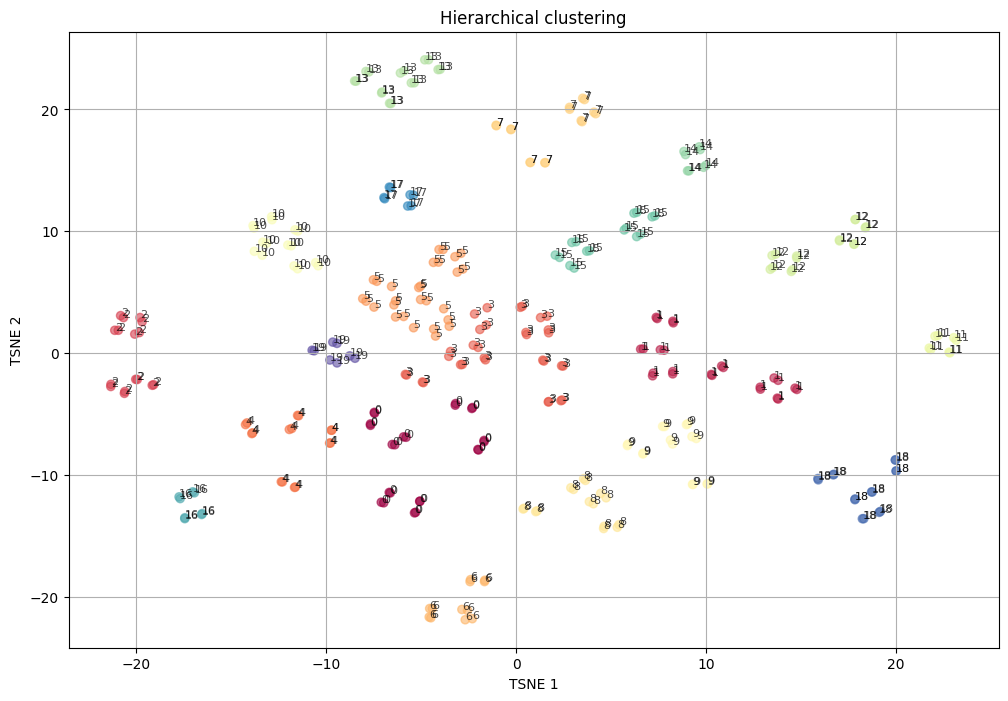

Class 0: 24 objects
Class 1: 24 objects
Class 2: 16 objects
Class 3: 32 objects
Class 4: 16 objects
Class 5: 28 objects
Class 6: 12 objects
Class 7: 16 objects
Class 8: 16 objects
Class 9: 16 objects
Class 10: 16 objects
Class 11: 8 objects
Class 12: 16 objects
Class 13: 16 objects
Class 14: 8 objects
Class 15: 16 objects
Class 16: 8 objects
Class 17: 8 objects
Class 18: 16 objects
Class 19: 8 objects


In [12]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from collections import Counter

data = output_tsne

n_clusters = 20  
model = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
clusters = model.fit_predict(data)

cluster_counts = Counter(clusters)
counts_array = np.array([cluster_counts[i] for i in range(n_clusters)])

plt.figure(figsize=(12, 8))
scatter = plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='Spectral', alpha=0.6)

for i, (x, y) in enumerate(data):
    plt.text(x, y, str(clusters[i]), fontsize=8, color='black', alpha=0.7)

plt.title('Hierarchical clustering')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.grid()
plt.show()

for i, count in enumerate(counts_array):
    print(f'Class {i}: {count} objects')

In [7]:
pd.DataFrame({'prediction': clusters, 'TSNE 1': data[:, 0], 'TSNE 2': data[:, 1]}).to_csv('submission_246->200_aglomerative.csv', index=False)

## Using `change_classes.py` to update dot classes based on our opinion

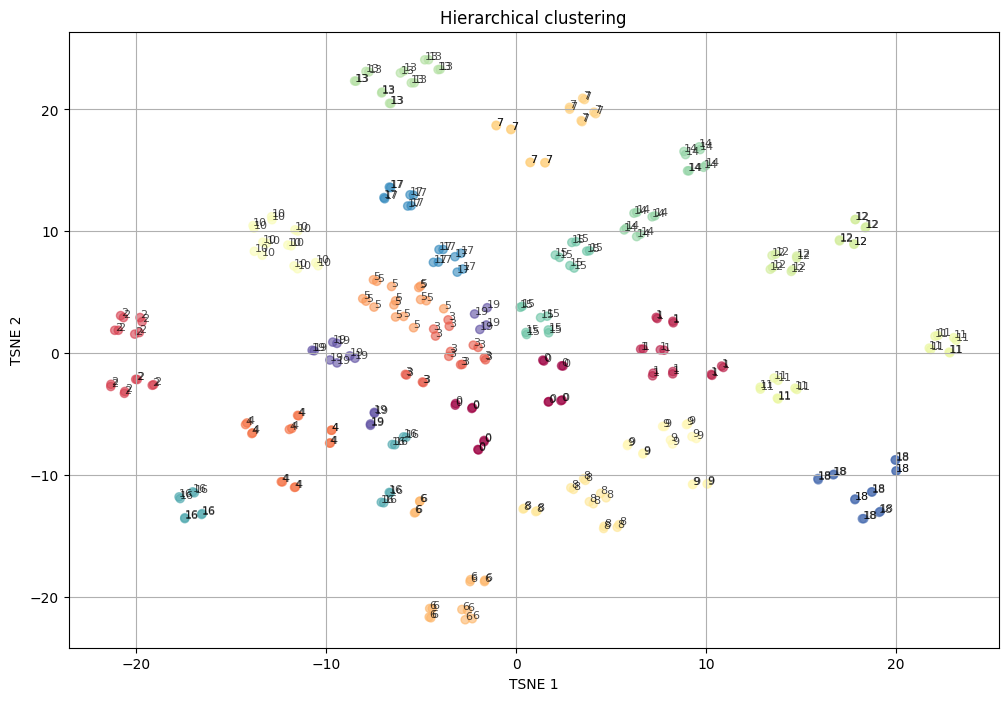

Class 0: 16 objects
Class 1: 16 objects
Class 2: 16 objects
Class 3: 16 objects
Class 4: 16 objects
Class 5: 16 objects
Class 6: 16 objects
Class 7: 16 objects
Class 8: 16 objects
Class 9: 16 objects
Class 10: 16 objects
Class 11: 16 objects
Class 12: 16 objects
Class 13: 16 objects
Class 14: 16 objects
Class 15: 16 objects
Class 16: 16 objects
Class 17: 16 objects
Class 18: 16 objects
Class 19: 16 objects


In [13]:
df = pd.read_csv('submission_246->200_aglomerative.csv')

clusters = df['prediction'].values
data = df[['TSNE 1', 'TSNE 2']].values

cluster_counts = Counter(clusters)

counts_array = np.array([cluster_counts[i] for i in range(n_clusters)])

plt.figure(figsize=(12, 8))
scatter = plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='Spectral', alpha=0.6)

for i, (x, y) in enumerate(data):
    plt.text(x, y, str(clusters[i]), fontsize=8, color='black', alpha=0.7)

plt.title('Hierarchical clustering')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.grid()
plt.show()

for i, count in enumerate(counts_array):
    print(f'Class {i}: {count} objects')

pd.DataFrame({'prediction': clusters}).to_csv('submission.csv', index=False)